In [6]:
using DelimitedFiles
using StatsBase
using Distributions
using LinearAlgebra
using Main

<p1>Two optimal policies π1 and π2 can lead to the same expected return (a.k.a state value function) even though they take different actions in a specific state s. Hence, even though the optimal policy that you derived takes a different action compared to the text book, the sequence of actions eventually leads to the same expected return (a.k.a state value function), hence both policies are optimal.</p1>

In [7]:
# this is on-policy every-visit MC control because we do not check for
# 1st visits to states; however, for the game of blackjack, it's not
# possible to visit the same state twice in an episode. you could have
# an ace being counted as 11, and then later being counted as 1, but
# the indicator for a usable ace is part of the state.  also, note
# that we maintain exploration of nonoptimal actions in the function
# blackjack().
# solving the black jack game described in example 5.1
using Random, StatsBase

# the face values for a suit
# ace through nine, ten, jack, queen, king
# note that 1=ace
suit = vcat(1, collect(2:9), 10, 10, 10, 10)
# a deck of cards consists of four suits: diamonds, clubs, hearts, spades
deck = repeat(suit,4)
shuffle!(deck)     # a random permutation
# to simulate an infinite deck, we can sample with replacement
deal_cards(n) = sample(deck, n, replace=true)
# note that it's quite possible (in fact it's common) to have more than
# one ace in a hand, but it's not possible to have two "usable" aces.
# 1/2 = no/yes
usable_ace(hand) = (any(hand .== 1) && sum(hand) <= 11) ? 2 : 1
score(hand) = sum(hand) + (usable_ace(hand)==2 ? 10 : 0)
# simulate an episode of blackjack according to policy π
function blackjack(π, ϵ = 0.05)
    player = deal_cards(2)
    dealer = deal_cards(2)
    action = []
    while score(player) < 12
        append!(player, deal_cards(1)) 
    end
    states = [[score(player), dealer[1] ,usable_ace(player)]]
    if states[1] == 21 && states[3] == 2
        push!(action, 2)
        if score(dealer) == 21  && usable_ace(dealer) == 2
            return states, action, 0
        else
            return states, action, 1
        end
    end
    while true 
        a = π[states[length(states)][1]-11,states[length(states)][2], states[length(states)][3]]#determine the action a according to policy
        if rand() < ϵ
            if a == 1
               a=2         
            else
                a = 1
            end
        end
        if a == 2
            push!(action,a)        
            break
        else
            push!(action, a)
            append!(player, deal_cards(1))
            if score(player) > 21
                return states, action, -1.0
            else
                push!(states,[ score(player), dealer[1] , usable_ace(player)])
            
            end
        end
    end
    while score(dealer)<17                      
        append!(dealer, deal_cards(1))
    end
    if score(dealer) > 21 || states[length(states)][1]> score(dealer)
        r =1.0
    elseif states[length(states)][1]< score(dealer)
        r = -1.0
    else
        r = 0.0
    end
    return states, action, r 
end
# this is on-policy every-visit MC control because we do not check for
# 1st visits to states; however, for the game of blackjack, it's not
# possible to visit the same state twice in an episode. you could have
# an ace being counted as 11, and then later being counted as 1, but
# the indicator for a usable ace is part of the state.  also, note
# that we maintain exploration of nonoptimal actions in the function
# blackjack().
function MC!(q, qn, π, S)
    for i = 1:10e6
        i % 1000000 == 0 && println("episode ", i)
        states, actions, r = blackjack(π)
        @assert(length(states) == length(actions))
        @assert( r in [-1.0, 0.0, 1.0])
        T = length(states)
        for t = 1:T
            s = states[t]
            a= actions[t]
            qn[s[1]-11, s[2], s[3],a] += 1 #updating qn
            q[s[1]-11, s[2], s[3], a] += r  #updating q    
            S[s[1]-11, s[2], s[3]], maxaction = findmax( q[s[1]-11, s[2], s[3],:]./ qn[s[1]-11, s[2], s[3], :])# find the action that maxmizes q for state s
            π[s[1]-11, s[2], s[3]] = maxaction    # update the policy greedily 
        end
    end
end

# the state space consists of
# the player's sum 12:21,
# the dealer's showing card 1:10,
# and indicator for usable ace no/yes=1/2
# for a total of 200 possible states.
# the action is hit/stick=1/2
# the initial policy is to stick when the player's sum is 20 or 21, otherwise hit
π = fill(1, (10, 10, 2))
π[9:10,:,:] .= 2           # stick when sum is 20 or 21 
q = zeros(10, 10, 2, 2)    # q(state=(player,dealer,usable), action)
qn = zeros(10, 10, 2, 2)   # to hold the number of observations
S =  zeros(10, 10, 2)
MC!(q, qn, π, S)


episode 1.0e6
episode 2.0e6
episode 3.0e6
episode 4.0e6
episode 5.0e6
episode 6.0e6
episode 7.0e6
episode 8.0e6
episode 9.0e6
episode 1.0e7


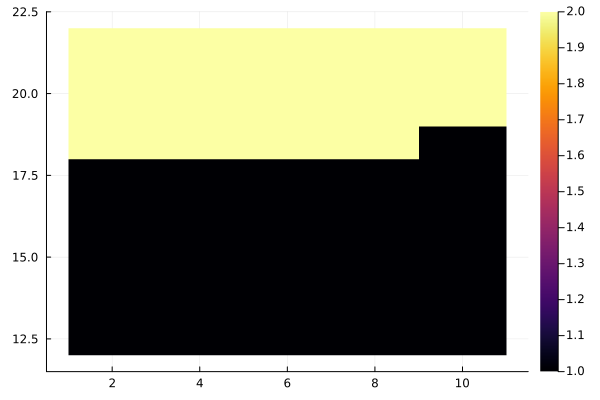

In [8]:
import Plots
x=range(1,11)
y = range(1,11)
Plots.heatmap(x , y.+11, π[:, :,2]) #heatmap of usable ace x axis = dealer showing, yaxis =  player sum 12 to 21

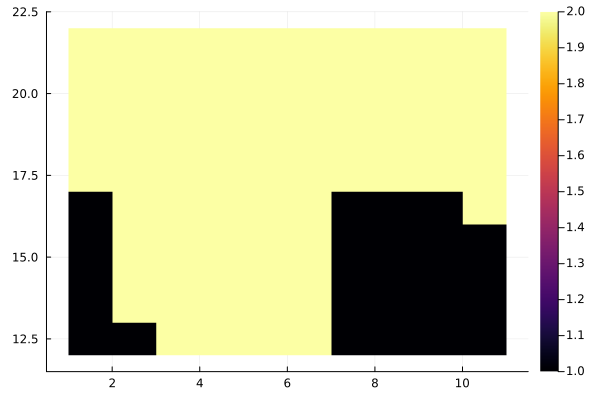

In [9]:
x = range(1,11)
y = range(1,11)
Plots.heatmap(x, y.+ 11, π[:, :,1]) #heatmap of nonusable ace 


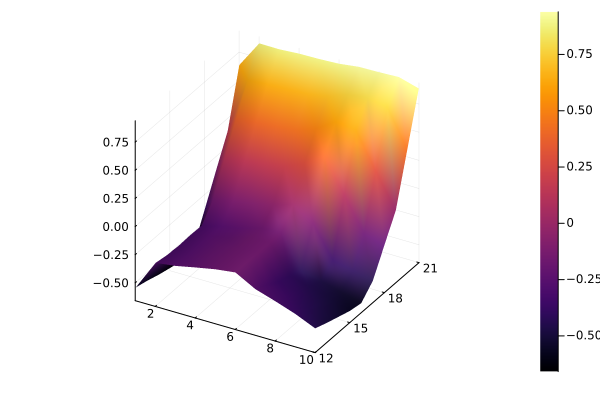

In [10]:
# some helpful things in Julia?

using Plots
# two functions named f exist. they have different signatures
y = range(1,10) #for the player 
x= range(1,10) #for the dealer
Plots.surface(x, y.+11, S[y,x,1]) #non usable ace consider x = current value showing + 11  because x is the player sum

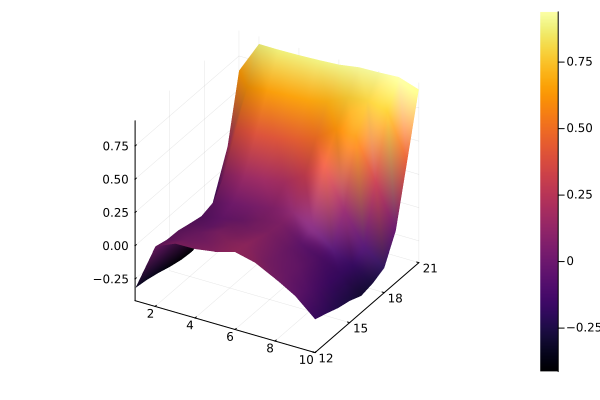

In [11]:
Plots.surface(x, y.+11, S[y,x,2])  #surface plot of the usable ace